In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Column, Integer, String, Float, and_, Date, desc, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
engine.execute('select min(date), max(date) from measurement').fetchall()

[('2010-01-01', '2017-08-23')]

In [14]:
# Capture the start and end dates of the trip
date_entry = input('Enter a start date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
start_date = dt.date(year, month, day)

date_entry = input('Enter an end date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
end_date = dt.date(year, month, day)

Enter a start date for your trip in YYYY-MM-DD format: 2016-08-20
Enter an end date for your trip in YYYY-MM-DD format: 2016-08-27


# Exploratory Climate Analysis

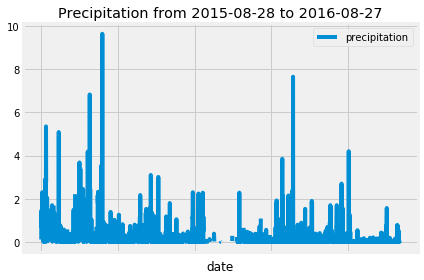

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
ly = end_date - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
prcp_ly = session.query(Measurement.date, Measurement.prcp).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= ly)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_ly, columns=["date", "precipitation"])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.iloc[::-1].plot(title="Precipitation from %s to %s" % (ly, end_date))
plt.tight_layout()
plt.show()

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2073.000000
mean,0.223126
std,0.561596
min,0.000000
25%,0.000000
50%,0.030000
75%,0.190000
max,9.640000


In [46]:
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [41]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
print("The total number of stations are: %s" % total_stations)

The total number of stations are: 9


In [47]:
# List the stations and the counts in descending order.
all_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()
all_stations

# What are the most active stations? (i.e. what stations have the most rows)?
top_active = all_stations[0][0]
tot_obs = all_stations[0][1]

print("The most active station is: %s" % top_active)
print("The total number of observations: %s" % (tot_obs))

The most active station is: USC00519281
The total number of observations: 2772


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute('select min(tobs) as low_temp, max(tobs) as high_temp, avg(tobs) as avg_temp from measurement where station="USC00519281"').fetchall()

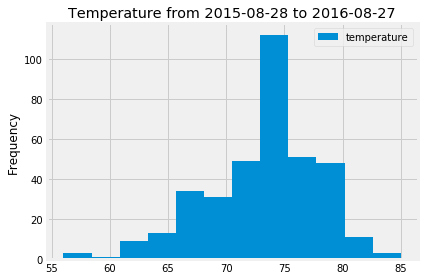

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_ly = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= ly,
                                                                         Measurement.station == top_active)).all()

# create the dataframe and set date as the index
temp_df = pd.DataFrame(temp_ly, columns = ["date", "temperature"])
temp_df.set_index('date', inplace=True)

# create a histogram of the temperature data
temp_df.iloc[::-1].plot.hist(title="Temperature from %s to %s" % (ly, end_date), bins = 12)
plt.tight_layout()
plt.show()

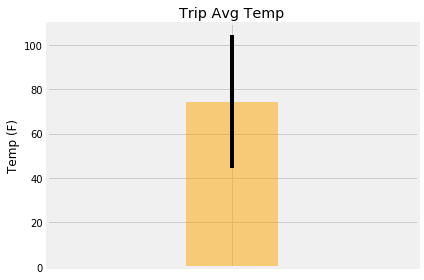

In [69]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
def calc_temps(start_dt, end_dt):
    # calculate the date 1 year ago
    one_year = end_dt - dt.timedelta(365)
    
    # get the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(and_(Measurement.date <= end_dt, Measurement.date >= one_year)).all()
    maximum = max_temp[0][0]
    
    # get the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(and_(Measurement.date <= end_dt, Measurement.date >= one_year)).all()
    minimum = min_temp[0][0]
    
    # get the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(and_(Measurement.date <= end_dt, Measurement.date >= one_year)).all()
    average = avg_temp[0][0]
    
    # create the plot
    objects = [str(end_dt)]
    x_axis = np.arange(len(objects))
    fig, ax = plt.subplots()
    temp_plot = ax.bar(x_axis, average, yerr=(maximum-minimum), color = "orange", alpha = .5, width = .5)
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, [])
    plt.xlim(-1, len(x_axis))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.tight_layout()
    plt.show()

# function call
calc_temps(start_date, end_date)